In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import networkx as nx
from collections import Counter
import gc
from prophet import Prophet

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import random

# Sample settings
sample_fraction = 0.05  # Read 5% of each file

# OCT file
filename_oct = '/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv'
with open(filename_oct) as f:
    total_lines_oct = sum(1 for line in f)

skip_rows_oct = sorted(random.sample(range(1, total_lines_oct), int((1 - sample_fraction) * (total_lines_oct - 1))))

df_filled_oct = pd.read_csv(filename_oct, skiprows=skip_rows_oct)

# NOV file
filename_nov = '/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv'
with open(filename_nov) as f:
    total_lines_nov = sum(1 for line in f)

skip_rows_nov = sorted(random.sample(range(1, total_lines_nov), int((1 - sample_fraction) * (total_lines_nov - 1))))

df_filled_nov = pd.read_csv(filename_nov, skiprows=skip_rows_nov)

# Then you can concatenate them if needed
df_combined = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

print(df_combined.shape)


(5497538, 9)


# Analyzing browsing and purchasing patterns

In [ ]:
#1. Distribution of event types (view, cart, purchase, remove_from_cart)

import matplotlib.pyplot as plt

event_counts = df_combined['event_type'].value_counts()

# Bar plot
event_counts.plot(kind='bar')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

print(event_counts)

In [ ]:
#2. Session Funnel Analysis
#What % of sessions have each type of event?
# Group by user_session
session_event_types = df_combined.groupby('user_session')['event_type'].unique()

# Count sessions that have view, cart, and purchase
view_sessions = session_event_types.apply(lambda x: 'view' in x).sum()
cart_sessions = session_event_types.apply(lambda x: 'cart' in x).sum()
purchase_sessions = session_event_types.apply(lambda x: 'purchase' in x).sum()

total_sessions = len(session_event_types)

print(f"Total sessions: {total_sessions}")
print(f"Sessions with view: {view_sessions} ({view_sessions/total_sessions:.2%})")
print(f"Sessions with cart: {cart_sessions} ({cart_sessions/total_sessions:.2%})")
print(f"Sessions with purchase: {purchase_sessions} ({purchase_sessions/total_sessions:.2%})")


In [ ]:
#3. Top Viewed and Purchased Products
#Are the most viewed products also the most purchased?
# Top viewed products
top_viewed = df_combined[df_combined['event_type'] == 'view']['product_id'].value_counts().head(10)

# Top purchased products
top_purchased = df_combined[df_combined['event_type'] == 'purchase']['product_id'].value_counts().head(10)

print("Top viewed products:\n", top_viewed)
print("\nTop purchased products:\n", top_purchased)


In [ ]:
#4. Events per Session
#How "long" are sessions? (1–2 clicks vs 10–20 clicks)
session_event_counts = df_combined.groupby('user_session').size()

# Plot histogram
session_event_counts.plot(kind='hist', bins=30)
plt.title('Number of Events per Session')
plt.xlabel('Number of Events')
plt.ylabel('Number of Sessions')
plt.show()

print(session_event_counts.describe())


In [ ]:
#5. Time-based Patterns
#When do users shop or browse the most? (Morning, afternoon, night?)
# Convert event_time to datetime
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# Extract hour
df_combined['event_hour'] = df_combined['event_time'].dt.hour

hourly_events = df_combined.groupby('event_hour').size()

# Plot
hourly_events.plot(kind='line')
plt.title('Events by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Event Count')
plt.grid()
plt.show()


In [ ]:
#6. Conversion Rates by Category
## Views per category
views_per_cat = df_combined[df_combined['event_type'] == 'view']['category_code'].value_counts()

# Purchases per category
purchases_per_cat = df_combined[df_combined['event_type'] == 'purchase']['category_code'].value_counts()

# Conversion rate
conversion_rate = (purchases_per_cat / views_per_cat) * 100
conversion_rate = conversion_rate.dropna().sort_values(ascending=False).head(10)

print(conversion_rate)


In [ ]:
#7. Price Analysis: Browsed vs Purchased
#Are cheaper or more expensive products bought more often?
avg_view_price = df_combined[df_combined['event_type'] == 'view']['price'].mean()
avg_purchase_price = df_combined[df_combined['event_type'] == 'purchase']['price'].mean()

print(f"Average price of viewed products: ${avg_view_price:.2f}")
print(f"Average price of purchased products: ${avg_purchase_price:.2f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 8. Heatmap of Purchase Timing
# -------------------------------------

title = "8. Heatmap of Purchase Timing"

# Extract time features (if not done already)
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Filter purchases only
purchases = df_combined[df_combined['event_type'] == 'purchase']

# Aggregate purchase counts by day and hour
heatmap_data = purchases.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data,
    cmap='Blues',
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Number of Purchases'}
)

plt.xlabel("Hour of the Day (24h format)")
plt.ylabel("Day of the Week")
plt.title("Purchase Activity Heatmap (by Day and Hour)", fontsize=16, pad=15)

# Set better day labels
plt.yticks(
    ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],
    labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Dashboard for Event Type Distribution, Purchase Heatmap, Top Products Purchased, Session Funnel

In [ ]:
# 1. Event type distribution
import plotly.express as px # use Plotly Express to create bar charts

event_counts = df_combined['event_type'].value_counts().reset_index() #Count how many times each event types appear
event_counts.columns = ['event_type', 'count']

fig1 = px.bar(event_counts, x='event_type', y='count', color='event_type',
              title='Event Type Distribution')
fig1.show() # display interactively

# 2. Purchase heat map (hour and day) - When the purchases were made
# Convert event_time to datetime
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
# Extracts the hour of the day and day of the week
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek

# Heatmap data
heatmap_data = df_combined[df_combined['event_type'] == 'purchase'] \
    .groupby(['day_of_week', 'hour']).size().reset_index(name='purchases')

fig2 = px.density_heatmap(heatmap_data, x='hour', y='day_of_week', z='purchases',
                          title='Heatmap of Purchases by Hour and Day',
                          labels={'day_of_week': 'Day of Week'},
                          color_continuous_scale='Blues')
fig2.update_yaxes(tickvals=list(range(7)), ticktext=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
fig2.show()

# 3. Top purchased products
# Recalculate in case earlier step failed
top_products = df_combined[df_combined['event_type'] == 'purchase']['product_id'] \
    .value_counts().reset_index().head(10)
top_products.columns = ['product_id', 'count']
top_products['product_id'] = top_products['product_id'].astype(str)  # Ensure it's categorical

# Check if non-empty
if not top_products.empty:
    fig = px.bar(top_products, x='product_id', y='count',
                 title='Top 10 Purchased Products',
                 text='count')
    fig.update_layout(xaxis_title='Product ID', yaxis_title='Count')
    fig.show()
else:
    print("⚠️ No purchase events found in the dataset.")

# 4. Top purchased category
# Get top 10 most purchased categories
top_categories = df_combined[df_combined['event_type'] == 'purchase']['category_code'] \
    .value_counts().reset_index().head(10)

top_categories.columns = ['category_code', 'count']
top_categories['category_code'] = top_categories['category_code'].astype(str)  # Ensure it's categorical

# Drop missing if needed
top_categories = top_categories[top_categories['category_code'] != 'nan']

# Plot
fig4 = px.bar(top_categories, x='category_code', y='count',
             title='Top 10 Purchased Categories',
             text='count')
fig4.update_layout(xaxis_title='Category', yaxis_title='Purchase Count')
fig4.show()


# 5. Session Funnel (View-->Cart-->Purchase)
# Funnel: sessions with each event type
session_events = df_combined.groupby('user_session')['event_type'].apply(set)
#Count sessions for each event type
view_sessions = session_events.apply(lambda x: 'view' in x).sum()
cart_sessions = session_events.apply(lambda x: 'cart' in x).sum()
purchase_sessions = session_events.apply(lambda x: 'purchase' in x).sum()

funnel_data = {
    'Stage': ['Viewed', 'Added to Cart', 'Purchased'],
    'Sessions': [view_sessions, cart_sessions, purchase_sessions]
}

fig5 = px.funnel(funnel_data, x='Sessions', y='Stage',
                 title='Session Funnel: View → Cart → Purchase')
fig5.show()

#Combine all in a single pannel
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig.write_html("dashboard.html")


# Clustering users based on behavior

In [ ]:
#1. Create Behavioral Features
#Features to extract:
#Total number of views, carts, purchases
#Total sessions
#Average price of viewed products
#Average price of purchased products
#Number of different categories interacted
#Instead of filtering inside the agg, split the dataset first into views and purchases separately!
# 1. Pre-filter datasets
views = df_combined[df_combined['event_type'] == 'view']
purchases = df_combined[df_combined['event_type'] == 'purchase']

# 2. Aggregate basic counts
user_behavior = df_combined.groupby('user_id').agg(
    total_events=('event_type', 'count'),
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_carts=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum()),
    unique_sessions=('user_session', pd.Series.nunique),
    unique_categories=('category_code', pd.Series.nunique)
)

# 3. Compute avg_view_price separately
avg_view_price = views.groupby('user_id')['price'].mean()
avg_purchase_price = purchases.groupby('user_id')['price'].mean()

# 4. Merge back
user_behavior = user_behavior.merge(avg_view_price.rename('avg_view_price'), how='left', left_index=True, right_index=True)
user_behavior = user_behavior.merge(avg_purchase_price.rename('avg_purchase_price'), how='left', left_index=True, right_index=True)

# 5. Fill missing
user_behavior['avg_view_price'] = user_behavior['avg_view_price'].fillna(0)
user_behavior['avg_purchase_price'] = user_behavior['avg_purchase_price'].fillna(0)

print(user_behavior.head())


          total_events  total_views  total_carts  total_purchases  \
user_id                                                             
29515875             1            1            0                0   
31198833             1            1            0                0   
43295513             1            1            0                0   
49484535             1            1            0                0   
62336140             3            3            0                0   

          unique_sessions  unique_categories  avg_view_price  \
user_id                                                        
29515875                1                  1          514.81   
31198833                1                  1          437.59   
43295513                1                  1           91.47   
49484535                1                  1           55.34   
62336140                2                  1          177.35   

          avg_purchase_price  
user_id                       
29515

In [ ]:
#2. Standardize the Features
#Clustering algorithms (like KMeans) are sensitive to feature scale.
#We need to scale all features (mean 0, std 1):
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_behavior)

print(X_scaled.shape)


(1942159, 8)


In [ ]:
#3. Cluster Users with KMeans
#Users are group into 4 groups
from sklearn.cluster import KMeans

# Let's assume 4 clusters to start (you can tune later)
kmeans = KMeans(n_clusters=4, random_state=42)
user_behavior['cluster'] = kmeans.fit_predict(X_scaled)

print(user_behavior['cluster'].value_counts())


cluster
0    1579873
3     270447
1      66628
2      25211
Name: count, dtype: int64


         total_events  total_views  total_carts  total_purchases  \
cluster                                                            
0            1.666395     1.610712     0.055682         0.000001   
1            4.334184     2.822342     0.363031         1.148811   
2           26.287375    25.456190     0.638253         0.192932   
3            7.074717     6.809308     0.258217         0.007192   

         unique_sessions  unique_categories  avg_view_price  \
cluster                                                       
0               1.396977           1.184446      300.386435   
1               3.329936           1.844945      230.803988   
2              16.521558           6.143231      266.080485   
3               5.012169           3.106916      280.349775   

         avg_purchase_price  
cluster                      
0                  0.000004  
1                309.503721  
2                 24.473138  
3                  0.308590  


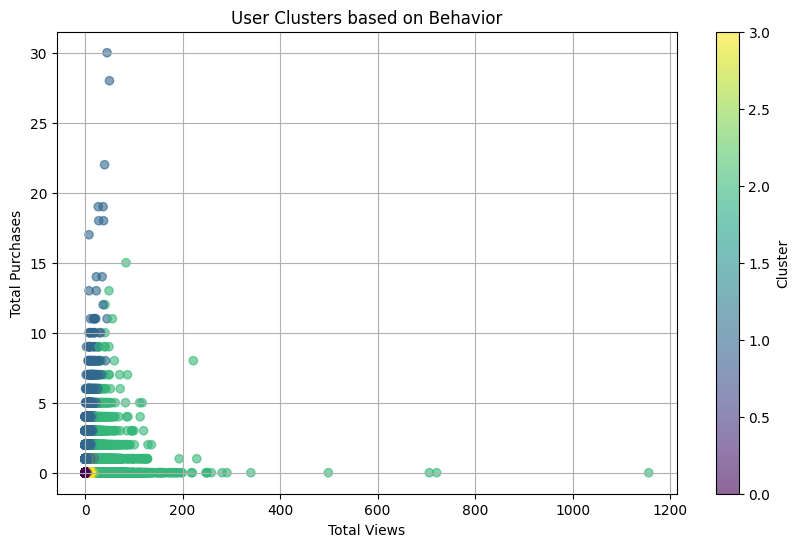

In [ ]:
#4. Analyze and Visualize the Clusters
cluster_summary = user_behavior.groupby('cluster').mean()
print(cluster_summary)

#plot the clusters using 2 features, e.g., total_purchases vs total_views
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    user_behavior['total_views'],
    user_behavior['total_purchases'],
    c=user_behavior['cluster'],
    cmap='viridis',
    alpha=0.6
)

plt.xlabel('Total Views')
plt.ylabel('Total Purchases')
plt.title('User Clusters based on Behavior')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# Time-sensitive recommendation system

In [ ]:
#1. Add Time Features to Dataset to segment purchases by month, hour, weekday.

# 1. Convert event_time to datetime
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'], errors='coerce')

# 2. Now safely extract time features
df_combined['month'] = df_combined['event_time'].dt.month
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek  # 0 = Monday, 6 = Sunday



In [ ]:
#2. Build Popular Products by Time Windows
# a ranked list of products for every month, hour, and weekday
# Popular products by month
monthly_popular = df_combined[df_combined['event_type'] == 'purchase'].groupby(['month', 'product_id']).size().reset_index(name='count')
monthly_top_products = monthly_popular.sort_values(['month', 'count'], ascending=[True, False])

# Popular products by hour
hourly_popular = df_combined[df_combined['event_type'] == 'purchase'].groupby(['hour', 'product_id']).size().reset_index(name='count')
hourly_top_products = hourly_popular.sort_values(['hour', 'count'], ascending=[True, False])

# Popular products by day_of_week
weekday_popular = df_combined[df_combined['event_type'] == 'purchase'].groupby(['day_of_week', 'product_id']).size().reset_index(name='count')
weekday_top_products = weekday_popular.sort_values(['day_of_week', 'count'], ascending=[True, False])

# Show top 5 products per month
for month in sorted(df_combined['month'].dropna().unique()):
    print(f"\n--- Top Products for Month {month} ---")
    top_products_month = monthly_top_products[monthly_top_products['month'] == month].head(5)
    print(top_products_month[['product_id', 'count']])


#Show top 5 products per Day of Week
day_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for day in sorted(df_combined['day_of_week'].dropna().unique()):
    print(f"\n--- Top Products for {day_mapping[int(day)]} ---")
    top_products_day = weekday_top_products[weekday_top_products['day_of_week'] == day].head(5)
    print(top_products_day[['product_id', 'count']])





--- Top Products for Month 10 ---
      product_id  count
320      1004856   1427
278      1004767   1134
447      1005115    631
304      1004833    596
2576     4804056    586

--- Top Products for Month 11 ---
       product_id  count
9172      1004856   1625
9137      1004767   1124
9291      1005115   1061
11737     4804056    894
9159      1004833    736

--- Top Products for Monday ---
      product_id  count
195      1004856    421
165      1004767    286
292      1005115    225
1225     4804056    191
184      1004833    179

--- Top Products for Tuesday ---
      product_id  count
3913     1004856    387
3883     1004767    311
4004     1005115    226
5022     4804056    188
3901     1004833    181

--- Top Products for Wednesday ---
      product_id  count
7740     1004856    414
7709     1004767    310
7728     1004833    195
8865     4804056    188
7834     1005115    187

--- Top Products for Thursday ---
       product_id  count
11680     1004856    420
11649     100476

In [ ]:
#3. Function to Recommend Based on Current Time
#At any moment, the system recommends time-relevant products.

import numpy as np

def recommend_products(current_time, n_recommendations=5):
    month = current_time.month
    hour = current_time.hour
    day_of_week = current_time.weekday()

    # Pick top products
    month_products = monthly_top_products[monthly_top_products['month'] == month]['product_id'].values
    hour_products = hourly_top_products[hourly_top_products['hour'] == hour]['product_id'].values
    weekday_products = weekday_top_products[weekday_top_products['day_of_week'] == day_of_week]['product_id'].values

    # Combine and rank (simple: just stack for now)
    combined_products = np.concatenate([month_products, hour_products, weekday_products])

    # Count frequency and recommend most common
    recommended_products, counts = np.unique(combined_products, return_counts=True)
    top_indices = np.argsort(-counts)  # Sort descending by frequency
    final_recommendations = recommended_products[top_indices][:n_recommendations]

    return final_recommendations

# Example use
from datetime import datetime

current_time = datetime.utcnow()
recommendations = recommend_products(current_time)
print("Recommended products:", recommendations)


Recommended products: [100009754   1002547   1002545   1002544   1002542]


In [ ]:
!pip install plotly
